In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import skimage.io
from skimage.measure import regionprops, regionprops_table
import pandas as pd 
import numpy.ma as ma
import cv2
import os 
from pathlib import Path

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Import path 
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

from config import *

In [4]:
# Define image and masks folder
info_csv = data_meta / 'all_info.csv'

df = pd.read_csv(info_csv)

In [36]:
def get_condition(df, condition):
    imgs_path = []
    markers = []

    df = df[(df.Condition == condition) & (df.Z_stack == 'Combined')]
    for row in df.itertuples():
        if row.Marker in ['DAPI','Phalloidin', 'WGA']:
            continue
        imgs_path.append(row.Path_corrected)
        markers.append(row.Marker)
    return imgs_path, markers

def get_masks(mask_folder):
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if 'tiff' in name:
                condition = name.split('_')[0]
                masks[condition] = masks.get(condition, {})
                filename = os.path.join(dirpath, name)
            if 'cyto' in name:
                img = skimage.io.imread(filename)
                masks[condition]['cyto'] = img 
            elif 'nuclei' in name:
                img = skimage.io.imread(filename)
                masks[condition]['nuclei'] = img
    return masks

def measure_prop(df, masks, show=False, save=False):
    appended_data_intensity = []
    appended_data_morphology = []

    # Get each segmented cell region with corresponding nuclei and cell
    for idx, condition in enumerate(masks.keys()):
        mask_cyto = masks[condition]['cyto']
        mask_nuclei = masks[condition]['nuclei']

        cell = np.zeros((mask_cyto.shape), dtype = np.uint8)
        nuclei = np.zeros((mask_cyto.shape), dtype = np.uint8)
        cyto = np.zeros((mask_cyto.shape), dtype = np.uint8)

        for label in range(1, mask_cyto.max()):
            # Check if cell has nuclei
            cell_mask = np.where(mask_cyto == label, 1, 0).astype(np.uint8)
            maski = cv2.bitwise_and(mask_nuclei, mask_nuclei, mask = cell_mask)

            # If no nuclei detected then pass
            if maski.max() == 0 :
                continue

            # Link label accross cell, nuclei, cyto
            cell = np.where(mask_cyto == label, label, cell)
            nuclei = np.where(maski > 0, label, nuclei)
            maski = cv2.subtract(cell_mask, maski)
            cyto = np.where(maski > 0, label, cyto)
            
        imgs, markers = get_condition(df, condition)
        for idx, img_path in enumerate(imgs):
            img = skimage.io.imread(img_path)
            cell_props = regionprops_table(cell, img, properties=['mean_intensity'])
            nuclei_props = regionprops_table(nuclei, img, properties=['mean_intensity'])
            cyto_props = regionprops_table(cyto, img, properties=['mean_intensity'])

            props = [cell_props, nuclei_props, cyto_props]
            prefix = ['Cell ', 'Nuclei ', 'Cyto ']
            df_marker = pd.concat([pd.DataFrame(prop).add_prefix(prefix[idx]) for idx, prop in enumerate(props)], axis = 1)
            df_marker['Marker'] = markers[idx]
            df_marker['Condition'] = condition
            df_marker['Id'] = df_marker.index
            appended_data_intensity.append(df_marker)

            if idx == 0:
                cell_props = regionprops_table(cell, img, properties=['area'])
                nuclei_props = regionprops_table(nuclei, img, properties=['area'])
                cyto_props = regionprops_table(cyto, img, properties=['area'])

                props = [cell_props, nuclei_props, cyto_props]
                prefix = ['Cell ', 'Nuclei ', 'Cyto ']
                df_marker = pd.concat([pd.DataFrame(prop).add_prefix(prefix[idx]) for idx, prop in enumerate(props)], axis = 1)
                df_marker['Marker'] = markers[idx]
                df_marker['Condition'] = condition
                df_marker['Id'] = df_marker.index
                appended_data_morphology.append(df_marker)
                
                if show:
                    fig, ax = plt.subplots(1,3, figsize=(15,5))
                    ax[0].imshow(cell)
                    ax[1].imshow(nuclei)
                    ax[2].imshow(cyto)
                    plt.show()
    

    df_prop_intensity = pd.concat(appended_data_intensity, ignore_index=True)
    df_prop_intensity = df_prop_intensity.sort_values(by=['Condition','Id']).reset_index(drop=True)

    df_prop_morph = pd.concat(appended_data_morphology, ignore_index=True)
    df_prop_morph = df_prop_morph.sort_values(by=['Condition','Id']).reset_index(drop=True)

    if save:
        df_prop_intensity.to_csv(data_meta / 'measurements_intensiy.csv', index=False)
        df_prop_morph.to_csv(data_meta / 'measurements_morphology.csv', index=False)

    return df_prop_intensity, df_prop_morph

In [37]:
masks = get_masks(data_mask)

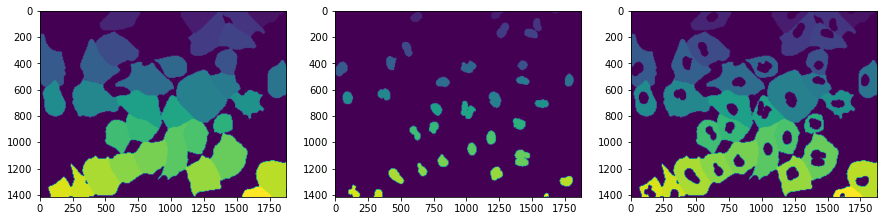

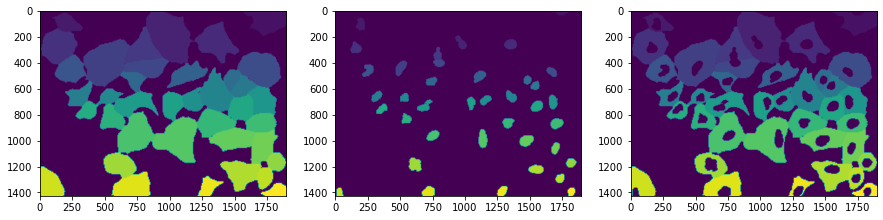

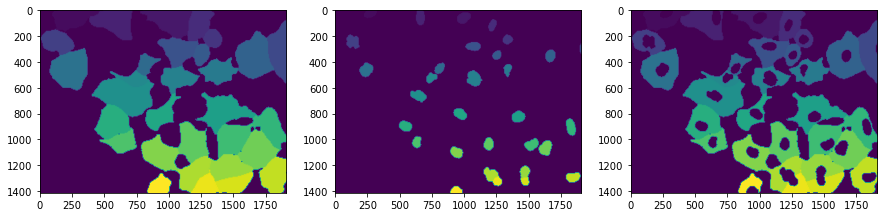

In [38]:
df_prop_i, df_prop_m = measure_prop(df, masks, save=True, show=True)

In [39]:
df_prop_i

,Cell mean_intensity,Nuclei mean_intensity,Cyto mean_intensity,Marker,Condition,Id
0,1473.307428,8407.890269,1117.442201,Concanavadin A,Fw1,0
1,213.940879,300.390269,209.504516,APC,Fw1,0
2,87.498029,94.752588,87.125744,Cyclin D1,Fw1,0
3,261.507276,895.098344,228.992988,Cyclin E,Fw1,0
4,225.033957,385.269151,216.811092,EMMPRIN,Fw1,0
...,...,...,...,...,...,...
819,484.493296,1284.717524,282.338974,Cyclin E,Fw3,30
820,377.179740,762.017575,279.961199,EMMPRIN,Fw3,30
821,151.947090,113.231279,161.727559,WNT-1,Fw3,30
822,472.497611,1455.043046,224.284924,Non-phospho-B-catenin,Fw3,30


In [40]:
df_prop_m

,Cell area,Nuclei area,Cyto area,Marker,Condition,Id
0,19790,966,18824,Concanavadin A,Fw1,0
1,28670,4147,24523,Concanavadin A,Fw1,1
2,34505,5023,29482,Concanavadin A,Fw1,2
3,31822,4938,26884,Concanavadin A,Fw1,3
4,53209,7220,45989,Concanavadin A,Fw1,4
...,...,...,...,...,...,...
98,41469,8254,33215,Concanavadin A,Fw3,26
99,46187,6860,39327,Concanavadin A,Fw3,27
100,29649,3447,26202,Concanavadin A,Fw3,28
101,21862,4002,17860,Concanavadin A,Fw3,29
